# [Project] 말라리아 감염 여부 예측 모델

---

## 프로젝트 목표
- 세포 이미지를 분석하여 Malaria 감염 여부를 진단
- 대량의 이미지 데이터를 전 처리하는 과정과 이에 따른 CNN 모델의 성능 변화를 학습

---

## 프로젝트 목차
1. **데이터 분석:** 이미지 데이터를 이루고 있는 요소에 대해서 Numpy를 사용하여 분석 및 확인

2. **데이터 전 처리:** 이미지 데이터를 읽어오고 딥러닝 모델의 입력으로 전 처리

3. **딥러닝 모델:** CNN 모델을 구현하고 학습, 평가 및 예측을 수행

---

## 데이터 출처
-  https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

---

## 프로젝트 개요

Artificial Intelligence (AI)가 우수한 성능을 보이면서 다양한 분야에서 Deep Learning 알고리즘을 적용하려는 시도가 이루어지고 있습니다. 헬스케어도 그 중 하나입니다. 저희는 세포 이미지를 분석하여 말라리아 감염 여부를 확인하는 프로젝트를 통해 기초적인 헬스케어 모델을 구현해 볼 것입니다.

말라이라 감염 예측 모델의 데이터는 말라리아에 감염된 세포 이미지와 감염되지 않은 정상 세포 이미지로 구성됩니다. 앞 서 배운  Convolutional Neural Network (CNN)을 활용하여 두 이미지를 분류하는 작업을 수행합니다.

---

미리 다운로드한 라이브러리를 import합니다. import는 라이브러리를 사용하기 위해 현재 interpreter 환경에 라이브러리 정보를 가져오는 것을 의미합니다.

In [1]:
import os
import shutil
import zipfile
import math
import pathlib
import time

import numpy as np
import pandas as pd
#import cv2 
import PIL
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

## 1. 데이터 분석 (EDA)

https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria 로부터 데이터를 다운로드하고 주피터 환경에 업로드합니다.
압축파일을 풀고, 프로젝트에 필요하지 않은 데이터 폴더는 지웁니다.

In [2]:
if not os.path.exists('/mnt/data/cell_images'):
    # 경로 안에 이 폴더가 없으면 압축을 풀어라
    start_time = time.time()
    malaria_zip = zipfile.ZipFile('archive.zip') 
    malaria_zip.extractall('/mnt/data') #unzip zip file
    malaria_zip.close()
    elapsed_time = time.time() - start_time
    print("Elapsed Time (unzip): {}".format(elapsed_time))
    
if os.path.exists('/mnt/data/cell_images/cell_images'):
    # 경로 안에 이 폴더가 있으면 가져와라
    start_time = time.time()
    shutil.rmtree('/mnt/data/cell_images/cell_images')
    elapsed_time = time.time() - start_time
    print("Elapsed Time (rm -r cell_images): {}".format(elapsed_time))

Elapsed Time (rm -r cell_images): 7.066113233566284


말라이아 감염 세포 이미지들이 있는 Parasitized 폴더와 정상 세포 이미지들이 포함되어 있는 Uninfected 폴더에 있는 이미지들의 개수를 확인합니다.

In [3]:
parasitized_list = os.listdir('/mnt/data/cell_images/Parasitized')
uninfected_list = os.listdir('/mnt/data/cell_images/Uninfected')

In [4]:
print('The number of parasitizedlen images : {}'.format(len(parasitized_list)))
print('The number of unifected images      : {}'.format(len(uninfected_list)))

The number of parasitizedlen images : 13780
The number of unifected images      : 13780


감염 세포와 정상 세포 이미지를 확인합니다.

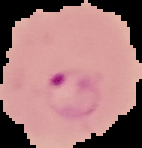

In [5]:
PIL.Image.open(os.path.join('/mnt/data/cell_images/Parasitized',parasitized_list[0]))

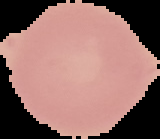

In [6]:
PIL.Image.open(os.path.join('/mnt/data/cell_images/Uninfected', uninfected_list[0]))

---

모델에 입력으로 들어갈 이미지의 크기와 한 번의 iteration에 모델에 넣어줄 batch 사이즈(이미지 개수)를 설정합니다.

In [7]:
train_malaria = pd.read_csv('csv/train_malaria.csv')
val_malaria = pd.read_csv('csv/val_malaria.csv')

In [8]:
train_malaria

,Path,ClassId
0,/mnt/data/cell_images/Parasitized/C39P4thinF_o...,Parasitized
1,/mnt/data/cell_images/Uninfected/C155P116ThinF...,Uninfected
2,/mnt/data/cell_images/Parasitized/C46P7ThinF_I...,Parasitized
3,/mnt/data/cell_images/Parasitized/C175P136NThi...,Parasitized
4,/mnt/data/cell_images/Parasitized/C91P52ThinF_...,Parasitized
...,...,...
16529,/mnt/data/cell_images/Parasitized/C129P90ThinF...,Parasitized
16530,/mnt/data/cell_images/Parasitized/C137P98ThinF...,Parasitized
16531,/mnt/data/cell_images/Uninfected/C236ThinF_IMG...,Uninfected
16532,/mnt/data/cell_images/Parasitized/C99P60ThinF_...,Parasitized


<BarContainer object of 2 artists>

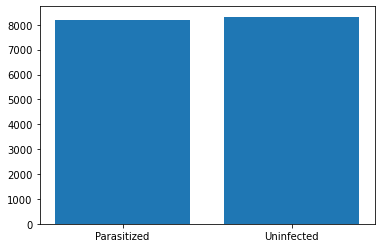

In [9]:
dict_train_malaria = {}

for cell in ['Parasitized', 'Uninfected']:
    dict_train_malaria[cell] = 0

for cell in train_malaria['ClassId']:
    dict_train_malaria[cell] += 1

plt.bar(dict_train_malaria.keys(), dict_train_malaria.values())

## 2. 데이터 전 처리

##### [assignment 1] train_datagen을 변경하여 학습해보기

train data와 validation data로 나눕니다. 이 과정에서 tensorflow.keras 패키지에서 제공하는 함수를 사용합니다. tf.keras.preprocessing.image.ImageDataGenerator는 기본적인 데이터 augmentation 기법을 제공합니다. 이미지 전처리 기법도 모델의 최종 성능을 높이는 좋은 방법입니다.

In [12]:
img_height = 128
img_width  = 128
batch_size = 32

In [24]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe   = train_malaria ,
        directory   = 'data',
        x_col       = 'Path', 
        y_col       = 'ClassId',
        target_size = (img_height, img_width),
        batch_size  = batch_size,
        shuffle     = False,
        class_mode  = 'binary')

val_generator = val_datagen.flow_from_dataframe(
        dataframe   = val_malaria,
        directory   = 'data',
        x_col       = 'Path',
        y_col       = 'ClassId',
        target_size = (img_height, img_width),
        batch_size  = batch_size,
        class_mode  = 'binary')

Found 16534 validated image filenames belonging to 2 classes.
Found 5512 validated image filenames belonging to 2 classes.


In [25]:
data_classes = train_generator.class_indices
num_classes = len(data_classes)
print('class: {}'.format(data_classes))

class: {'Parasitized': 0, 'Uninfected': 1}


In [26]:
for image_batch, labels_batch in train_generator:
    print(labels_batch)
    break

[0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 1.]


In [27]:
for image_batch, labels_batch in val_generator:
    print(labels_batch)
    break

[1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 0. 0.]


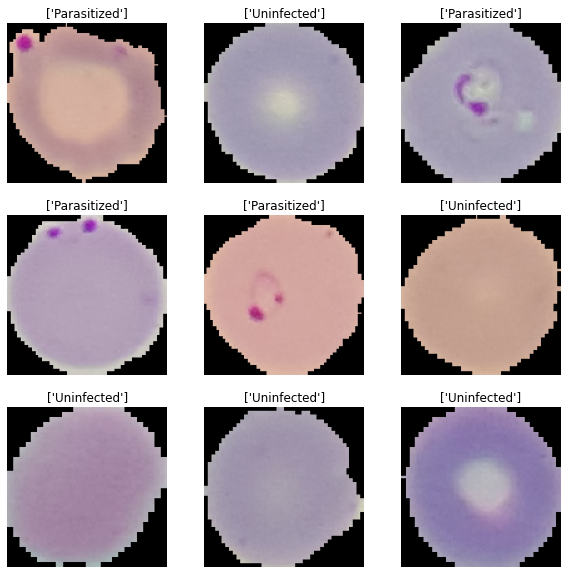

In [28]:
plt.figure(figsize=(10, 10))
images, labels = train_generator[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    key = [key for key, value in data_classes.items() if value  == labels[i]]
    plt.title(key)
    plt.axis("off")

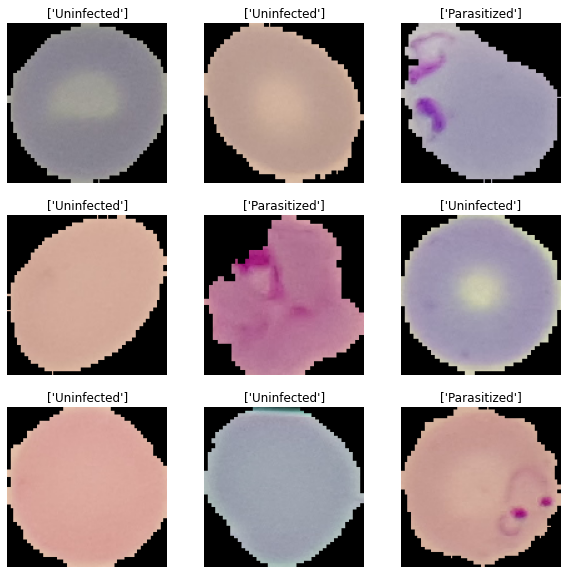

In [29]:
plt.figure(figsize=(10, 10))
images, labels = val_generator[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    key = [key for key, value in data_classes.items() if value  == labels[i]]
    plt.title(key)
    plt.axis("off")

---

## 3. Convolutional Neural Network (CNN) 모델

model.summary()는 모델의 구성을 한 눈에 확인할 수 있게 도와줍니다.

##### [assignment 2] 모델 구조를 수정해보기

In [30]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

---

### https://www.tensorflow.org/api_docs/python/tf/keras/Model

##### [assignment 3] optimizer 변경해보기

In [31]:
opt = tf.keras.optimizers.SGD(lr=0.001) 

model.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs=20

학습 전 weight

In [32]:
print(model.layers[0].get_weights()) #before training

[array([[[[ 0.14592454, -0.1735349 ,  0.16748604, -0.09969223,
           0.08168545, -0.16748169,  0.04940756, -0.17732973,
           0.0870561 , -0.15339038,  0.08834559, -0.04953136,
           0.17918584,  0.12778151,  0.17806202, -0.18552974],
         [ 0.08042091, -0.17986365,  0.03835459,  0.08374935,
          -0.04601537, -0.08801125,  0.17647552,  0.12727585,
           0.07008728,  0.06414992, -0.18521279, -0.05339599,
           0.12346929, -0.14465772, -0.04767774,  0.08329418],
         [-0.15383103, -0.06688591,  0.13848469,  0.154046  ,
           0.0214601 , -0.08590736,  0.13392743, -0.04545984,
           0.14635766,  0.15455359, -0.1867741 , -0.14886536,
          -0.04902688,  0.00888772,  0.05503541, -0.07947344]],

        [[-0.06273714, -0.11928804,  0.17610249,  0.13925424,
          -0.05644131, -0.06823308, -0.02198951, -0.12698317,
           0.09376082,  0.14210182,  0.07001796, -0.10745643,
          -0.05739011,  0.07960367, -0.1740379 , -0.00258376],
 

In [33]:
# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
#              tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)]#,
#              #scheduler]

history = model.fit(
    x               = train_generator,      
    validation_data = val_generator,
    epochs          = epochs,
#     callbacks       = callbacks
)

Epoch 1/20
517/517 [==============================] - 106s 204ms/step - loss: 0.6899 - accuracy: 0.5347 - val_loss: 0.6820 - val_accuracy: 0.5390
Epoch 2/20
517/517 [==============================] - 102s 196ms/step - loss: 0.6745 - accuracy: 0.5947 - val_loss: 0.6654 - val_accuracy: 0.6221
Epoch 3/20
517/517 [==============================] - 103s 200ms/step - loss: 0.6611 - accuracy: 0.6136 - val_loss: 0.6495 - val_accuracy: 0.6361
Epoch 4/20
517/517 [==============================] - 104s 202ms/step - loss: 0.6525 - accuracy: 0.6182 - val_loss: 0.6622 - val_accuracy: 0.5934
Epoch 5/20
517/517 [==============================] - 108s 209ms/step - loss: 0.6338 - accuracy: 0.6395 - val_loss: 0.6234 - val_accuracy: 0.6567
Epoch 6/20
517/517 [==============================] - 116s 225ms/step - loss: 0.6291 - accuracy: 0.6491 - val_loss: 0.6187 - val_accuracy: 0.6627
Epoch 7/20
517/517 [==============================] - 108s 209ms/step - loss: 0.6237 - accuracy: 0.6562 - val_loss: 0.6173 -

학습 과정을 시각화하여 확인합니다. 학습이 진행되면서 loss는 줄고, accuracy는 올라가는 것을 확인할 수 있습니다.

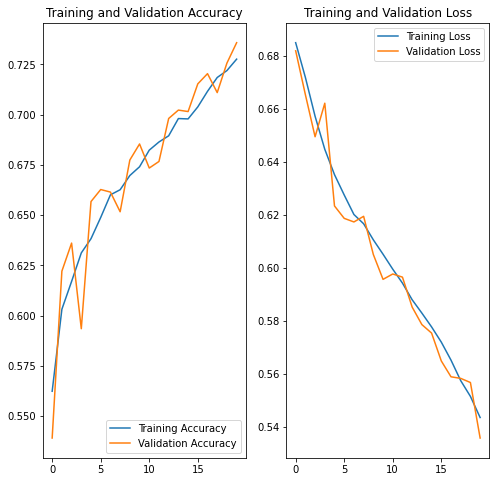

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

학습 후 weight. 학습 전 weight와 비교하여 달라졌음을 볼 수 있습니다. 즉, CNN이 학습되는 과정은 수많은 weigt를 학습하면서 모델이 예측에 필요한 feature를 사용할 수 있는 방향으로 업데이트된다는 것을 의미합니다.

In [35]:
print(model.layers[0].get_weights()) #after training

[array([[[[ 0.15658458, -0.17355032,  0.16396765, -0.09825354,
           0.07305456, -0.1674815 ,  0.04199322, -0.17732973,
           0.09895592, -0.16341585,  0.1039528 , -0.04953126,
           0.1875034 ,  0.12672313,  0.17660071, -0.1855398 ],
         [ 0.07712761, -0.17987968,  0.0692436 ,  0.08500797,
          -0.06009633, -0.08801117,  0.21037838,  0.12727585,
           0.07871411,  0.06337775, -0.33521083, -0.05339589,
           0.07197505, -0.14524971, -0.10539474,  0.08328503],
         [-0.1446247 , -0.06690231,  0.12378552,  0.15544778,
           0.02985364, -0.08590731,  0.11756872, -0.04545984,
           0.15957034,  0.14802466, -0.14819969, -0.1488653 ,
          -0.02937472,  0.00803746,  0.06861425, -0.07948312]],

        [[-0.05254691, -0.11931995,  0.17130178,  0.1406847 ,
          -0.06426893, -0.06821024, -0.03021165, -0.12698317,
           0.10313578,  0.13102086,  0.09209445, -0.10744905,
          -0.04998177,  0.07794052, -0.17569801, -0.00261587],
 

학습 과정을 재설계하기 위하여 결과를 분석합니다. 아래의 표는 Confusion Matrix로, 세로 줄은 실제 값을, 가로 줄은 예측 값을 나타냅니다.

In [36]:
val_generator.reset()
val_prediction = model.predict(val_generator)
prediction = np.argmax(val_prediction, axis = 1)

In [37]:
prediction

array([1, 1, 0, ..., 1, 0, 0], dtype=int64)

In [38]:
cm = confusion_matrix(prediction, val_generator.labels)
print(cm)

[[1460 1368]
 [1362 1322]]


In [39]:
from sklearn.metrics import classification_report

target_name = ['Parasited', 'Uninfected']
print(classification_report(val_generator.labels, prediction, target_names = target_name))

              precision    recall  f1-score   support

   Parasited       0.52      0.52      0.52      2822
  Uninfected       0.49      0.49      0.49      2690

    accuracy                           0.50      5512
   macro avg       0.50      0.50      0.50      5512
weighted avg       0.50      0.50      0.50      5512



---

<span style="color:rgb(120, 120, 120)">본 학습 자료를 포함한 사이트 내 모든 자료의 저작권은 엘리스에 있으며 외부로의 무단 복제, 배포 및 전송을 불허합니다.

Copyright @ elice all rights reserved</span>